In [1]:
import pandas as pd
import random
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [25]:
import shap

# load JS visualization code to notebook
shap.initjs()

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [3]:
df = pd.read_csv('secondary_data.csv', ';')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20332\1633459544.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('secondary_data.csv', ';')


- сделать обзорный анализ выбранного датасета

In [38]:
pd.set_option('display.max_columns', None)
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,veil-color,has-ring,ring-type,habitat,season
0,1,15.26,x,g,o,0,e,c,w,16.95,17.09,w,w,1,g,d,w
1,1,16.60,x,g,o,0,e,f,w,17.99,18.19,w,w,1,g,d,u
2,1,14.07,x,g,o,0,e,f,w,17.80,17.74,w,w,1,g,d,w
3,1,14.17,f,h,e,0,e,c,w,15.77,15.98,w,w,1,p,d,w
4,1,14.64,x,h,o,0,e,d,w,16.53,17.20,w,w,1,p,d,w


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [6]:
df['class'].value_counts()

p    33888
e    27181
Name: class, dtype: int64

- сделать feature engineering

<span style="color:#8B0000"> У некоторых признаков заполняем пропуски рандомными значениями </span>

In [7]:
cat_nans = ['cap-surface', 'gill-attachment', 'gill-spacing','ring-type']

In [8]:
for cat in cat_nans:
    
    df[cat] = df[cat].fillna(0)
    cat_types=list(df[cat].unique())
    cat_types.remove(0)
    df[cat] = df[cat].apply(lambda x: x if x!=0 else random.choice(cat_types))


<span style="color:#8B0000"> Признаки, в которых ОЧЕНЬ много пропусков, в основном удалим (spore-print-color,veil-type,stem-surface,stem-root) кроме:<br>
Veil-color (цвет "вуали") сделаем равным цвету ножки гриба<br>
</span>

In [9]:
feat_to_del = ['spore-print-color','veil-type','stem-surface','stem-root']
for f in feat_to_del:
    df.drop(f, inplace=True, axis=1)

In [10]:
df.loc[df['veil-color'].isna(), 'veil-color'] = df['stem-color']

In [11]:
df['veil-color'].unique()

array(['w', 'y', 'n', 'u', 'b', 'l', 'r', 'p', 'e', 'k', 'g', 'o', 'f'],
      dtype=object)

In [12]:
df.isna().sum().sum()

0

In [13]:
df.loc[df['has-ring']=='t', 'has-ring'] = 1
df.loc[df['has-ring']=='f', 'has-ring'] = 0
df['has-ring'] = df['has-ring'].astype('int32')

In [14]:
df['has-ring'].value_counts()

0    45890
1    15179
Name: has-ring, dtype: int64

In [15]:
df.loc[df['does-bruise-or-bleed']=='t', 'does-bruise-or-bleed'] = 1
df.loc[df['does-bruise-or-bleed']=='f', 'does-bruise-or-bleed'] = 0
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].astype('int32')

In [16]:
df.loc[df['class']=='p', 'class'] = 1
df.loc[df['class']=='e', 'class'] = 0
df['class'] = df['class'].astype('int32')

In [17]:
df['class'].value_counts()

1    33888
0    27181
Name: class, dtype: int64

- обучить любой классификатор (какой вам нравится)

<span style="color:#8B0000"> Поскольку практически все признаки тут категориальные, будем обучать CatBoost</span>

In [18]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['class'], axis=1), df['class'], random_state=26, shuffle=True)

<span style="color:#8B0000"> *отбираем категор. и веществ. признаки*</span>

In [20]:
categorical_columns = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', \
                      'gill-spacing', 'gill-color', 'stem-color', 'veil-color', 'ring-type', 'habitat', 'season']
continuous_columns = ['cap-diameter', 'does-bruise-or-bleed', 'stem-height', 'stem-width', 'has-ring']

<span style="color:#8B0000">*обучаем модель CatBoost*</span>

In [21]:
modelCB = CatBoostClassifier(iterations=20, thread_count=2, random_state=26, silent=True)

In [22]:
modelCB = modelCB.fit(X_train, y_train, cat_features=categorical_columns)

In [23]:
preds = modelCB.predict_proba(X_test)[:, 1]

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.5278967326594215, F-Score=0.952, Precision=0.954, Recall=0.950


- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)

In [33]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(modelCB)
shap_values = explainer(X_train)

Т.к. датасет в основном состоит из категориальных признаков, весь набор лучше анализировать через plots.bar.<br>
По результатам ниже видно, что практически все признаки имеют ценность и важны. Самые важные признаки - размеры гриба и цвет его частей. Причем цвет ножки гриба имеет ценность 0, что неудивительно: в начале значений veil-color было мало, и veil-color стал равным stem-color (т.е. это теперь почти одно и то же; зато наглядно видно, что плохая была идея)

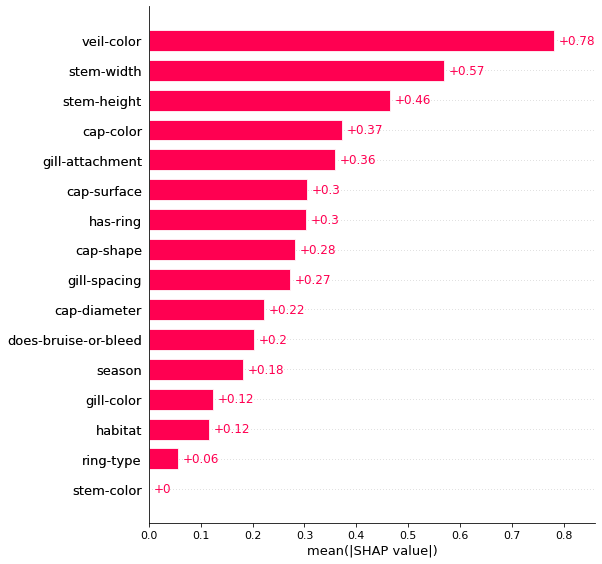

In [36]:
# summarize the effects of all the features
shap.plots.bar(shap_values, max_display=17)

Зато по summary-plot можно оценить вещественные признаки:<br>
- Чем толще ножка гриба, тем менее вероятно, что он ядовитый<br>
- С высотой наоборот: чем выше, тем ядовитее в среднем
- Если есть кольцо, скорее всего ядовитый
- Bruise-or-Bleed я так поняла это синюшность гриба или пятнистость. Так вот она влияет по-разному


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


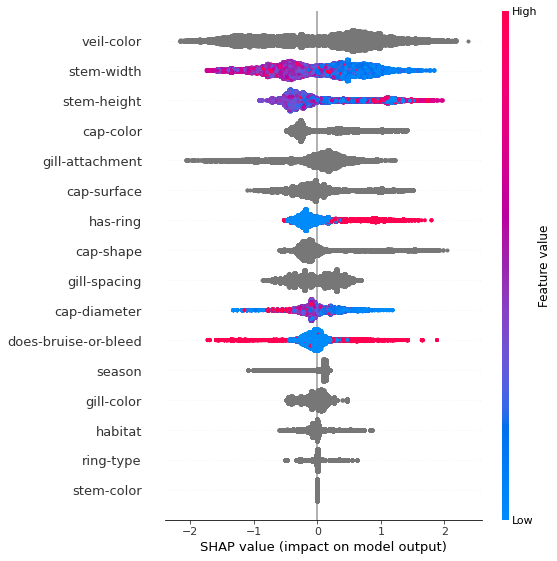

In [41]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

- для топ 10%

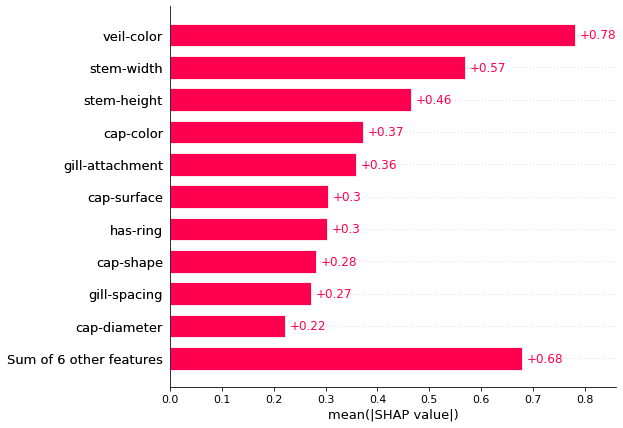

In [40]:
# summarize the effects of top10 features
shap.plots.bar(shap_values, max_display=11)

- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [45]:
shap_values = explainer.shap_values(X_train)

Цвет шляпки и ширина ножки вроде свидетельствовали о безопасности гриба<br>
Но вот цвет "вуали" и поверхность шляпки оказались очень уж подозрительными и сдвинули вероятность быть ядовитым вперёд

In [48]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

В примере ниже наоборот:
- Гриб подозрительно высокий для безопасного
- Но его пластиночки, цвет "вуали" и шляпки + ширина ножки очаровали модель и она решила, что он съедобный

In [47]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[26,:], X_train.iloc[26,:])

Ниже для модели более очевидная ситуация:
- Вроде есть небольшие сомнения из-за пластиночек и цвета шляпки
- Но и цвет вуали/ножки, и высота, и поверхность шляпки и много чего другого говорят о безопасности гриба


In [50]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[2600,:], X_train.iloc[2600,:])

Ссылка просто для себя, чтобы не потерять: https://towardsdatascience.com/shap-for-categorical-features-7c63e6a554ea